<a href="https://colab.research.google.com/github/pgupta7/Cycle_GAN_For_MonetConversion/blob/main/Supplementary_notbook_using_pix2pix_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color = 'blue'>
<font size = 6>
Supplemetary Notebook using pix2pix neural network architecture. For reference only - not an official submission. Please check the other notebook for the official submission of the project.


## Data download and libraries

<font color = 'blue'>
In the below cell, I download the data from the associated Kaggle competition.

In [ ]:
import kagglehub
gan_getting_started_path = kagglehub.competition_download('gan-getting-started')

print('Data source import complete.')

Data source import complete.


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
#listing the folders in the root directory
os.listdir(gan_getting_started_path)

['photo_tfrec', 'monet_tfrec', 'monet_jpg', 'photo_jpg']

In [ ]:
# loading the names of Monet image files
monet_files = os.listdir(os.path.join(gan_getting_started_path, 'monet_jpg'))
len(monet_files)

300

<font color = 'blue'>
Loading the names of the photographic image files. We will transform them to monet style.

In [ ]:
# loading the names of the photographic image files.
photo_files = os.listdir(os.path.join(gan_getting_started_path, 'photo_jpg'))
len(photo_files)

7038

In [ ]:
# Helper function to load the images
def load_image(image_path):
  image_path = os.path.join(image_path)
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  return image

<font color = 'blue'>
To train the cycle GAN algorithm, we will use only 300 of the over 7000 available phtographic images, which is equal to the number of Monet images avaiable. <br>
However, we are not conceptually limited to use equal number of photographic and Monet images. We can use more photographic images to train the neural networks, but it increases the running time. To keep the running time within reasonable limits, I chose to pair a photographic image with a unique Monet image while training the neural nets.

In [ ]:
#loading the images from the filenames
monet_train_images = [load_image(os.path.join(gan_getting_started_path, 'monet_jpg', i)) for i in monet_files]
photo_train_images = [load_image(os.path.join(gan_getting_started_path, 'photo_jpg', i)) for i in photo_files[:300]]

In [ ]:
# loading 10 photograhic images to test the algorithm after training.
photo_images = [load_image(os.path.join(gan_getting_started_path, 'photo_jpg', i)) for i in photo_files[310:320]]

<font color = 'blue'>
Next, I will convert the data to the tensor dataset format, which is more effiecient in neural net training than numpy arrays.

In [ ]:
monet_train_images = tf.data.Dataset.from_tensor_slices(monet_train_images)
photo_train_images = tf.data.Dataset.from_tensor_slices(photo_train_images)
photo_images = tf.data.Dataset.from_tensor_slices(photo_images)

In [ ]:
# Setting the useful constants for later use.
BUFFER_SIZE = 300
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

## Data preprocessing

<font color = 'blue'>
Next we apply random jittering and mirroring to the training datasets. These technique helps avoid overfitting.

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [ ]:
monet_train_images = monet_train_images.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
photo_train_images = photo_train_images.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_images = photo_images.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

## Model

<font color = 'blue'>
As mentioned at the beginning of the document, the cycle GAN technique is based on the conditional GAN method, i.e., pix2pix. Hence, as mentioned in the link provided at the Tensorflow tutorial on cycle-GAN, we will import the generators and the discriminators used in the pix2pix architecure.<br><br>
Moreover, considering that the project is just a week long, it is another reason to use the inbuilt architeccure from pix2pix.<br><br>
We will first install the tensorflow.examples library and then import the architecture from pix2pix.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-xn64v6xy
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-xn64v6xy
  Resolved https://github.com/tensorflow/examples.git to commit 6a3a323f3885f16085ad8335392f7ec836c677f4
  Preparing metadata (setup.py) ... done


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm', )
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

<font color = 'blue'>
Next, we will check out the architecture of the generators and the discriminators.<br><br>
The detailed architecture of the generators and discriminators can be found at the below location<br>
<a>https://www.tensorflow.org/tutorials/generative/pix2pix</a>, where a sequential layer in generator is formed froma Conv2D layer while the same in a dicscriminator is made of Copnv2DTranspose.

In [ ]:
generator_g.summary()

Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_76      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_72       │ (None, None,      │      3,072 │ input_layer_76[0… │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_73       │ (None, None,      │    131,328 │ sequential_72[0]… │
│ (Sequential)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_74       │ (None, None,      │    524,800 │ sequential_73[0]… │
│ (Sequential)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_75       │ (None, None,      │  2,098,176 │ sequential_74[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_76       │ (None, None,      │  4,195,328 │ sequential_75[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_77       │ (None, None,      │  4,195,328 │ sequential_76[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_78       │ (None, None,      │  4,195,328 │ sequential_77[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_79       │ (None, None,      │  4,195,328 │ sequential_78[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_80       │ (None, None,      │  4,195,328 │ sequential_79[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None,      │          0 │ sequential_80[0]… │
│ (Concatenate)       │ None, 128)        │            │ sequential_78[0]… │
│                     │                   │            │ sequential_81[0]… │
│                     │                   │            │ sequential_77[0]… │
│                     │                   │            │ sequential_82[0]… │
│                     │                   │            │ sequential_76[0]… │
│                     │                   │            │ sequential_83[0]… │
│                     │                   │            │ sequential_75[0]… │
│                     │                   │            │ sequential_84[0]… │
│                     │                   │            │ sequential_74[0]… │
│                     │                   │            │ sequential_85[0]… │
│                     │                   │            │ sequential_73[0]… │
│                     │                   │            │ sequential_86[0]… │
│                     │                   │            │ sequential_72[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_81       │ (None, None,      │  8,389,632 │ concatenate_4[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_82       │ (None, None,      │  8,389,632 │ concatenate_4[1]

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
generator_f.summary()

Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_92      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_87       │ (None, None,      │      3,072 │ input_layer_92[0… │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_88       │ (None, None,      │    131,328 │ sequential_87[0]… │
│ (Sequential)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_89       │ (None, None,      │    524,800 │ sequential_88[0]… │
│ (Sequential)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_90       │ (None, None,      │  2,098,176 │ sequential_89[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_91       │ (None, None,      │  4,195,328 │ sequential_90[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_92       │ (None, None,      │  4,195,328 │ sequential_91[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_93       │ (None, None,      │  4,195,328 │ sequential_92[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_94       │ (None, None,      │  4,195,328 │ sequential_93[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_95       │ (None, None,      │  4,195,328 │ sequential_94[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, None,      │          0 │ sequential_95[0]… │
│ (Concatenate)       │ None, 128)        │            │ sequential_93[0]… │
│                     │                   │            │ sequential_96[0]… │
│                     │                   │            │ sequential_92[0]… │
│                     │                   │            │ sequential_97[0]… │
│                     │                   │            │ sequential_91[0]… │
│                     │                   │            │ sequential_98[0]… │
│                     │                   │            │ sequential_90[0]… │
│                     │                   │            │ sequential_99[0]… │
│                     │                   │            │ sequential_89[0]… │
│                     │                   │            │ sequential_100[0… │
│                     │                   │            │ sequential_88[0]… │
│                     │                   │            │ sequential_101[0… │
│                     │                   │            │ sequential_87[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_96       │ (None, None,      │  8,389,632 │ concatenate_5[0]… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_97       │ (None, None,      │  8,389,632 │ concatenate_5[1]

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator_x.summary()

Model: "functional_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_102 (Sequential)     │ (None, None, None, 64) │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_103 (Sequential)     │ (None, None, None,     │       131,328 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_104 (Sequential)     │ (None, None, None,     │       524,800 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_8                │ (None, None, None,     │             0 │
│ (ZeroPadding2D)                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, None, None,     │     2,097,152 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_98       │ (None, None, None,     │         1,024 │
│ (InstanceNormalization)         │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_67 (LeakyReLU)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_9                │ (None, None, None,     │             0 │
│ (ZeroPadding2D)                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, None, None, 1)  │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator_y.summary()

Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_105 (Sequential)     │ (None, None, None, 64) │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_106 (Sequential)     │ (None, None, None,     │       131,328 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_107 (Sequential)     │ (None, None, None,     │       524,800 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_10               │ (None, None, None,     │             0 │
│ (ZeroPadding2D)                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, None, None,     │     2,097,152 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_101      │ (None, None, None,     │         1,024 │
│ (InstanceNormalization)         │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_11               │ (None, None, None,     │             0 │
│ (ZeroPadding2D)                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, None, None, 1)  │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

<font color = 'blue'>
Computing the losses.

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

<font color = 'blue'>
Discriminator losses come from comparing the real images to the real image labels and the

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

<font color = 'blue'>
Cycle loss and the identity loss are the additional losses that are part of the cycle-GAN algorithm.<br>
Identity loss compares the original image against the image genrated by the operation of alternate genrator. That is, If Y is a monet image and G is the generator to transform a photo image to a Monet, then identity loss also compares Y and G(Y). The assumption here being that G shouldn't cause much change to a Monet image, as it transforms a photo image to a Monet image. Similarly, identity loss also compares X and F(X), where X is a photo image and F transforms a Monet to a photo image. <br><br>
Additionally, if G transforms a photo image to a Monet and F transforms a Monet to a photo image, then the operation of G followed by F on a photo image should result in the same photo image and vice versa opration of G and F on a monet should result in the same Monet. Cyclic loss compares this original image to the one generated by this aformentioned cyclical operation.<br><br>

In [ ]:
# Cycle loss
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
# Identity loss
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)

In [ ]:
EPOCHS = 10

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(8, 8))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
sample_input = next(iter(photo_images))
# sample_input[0]

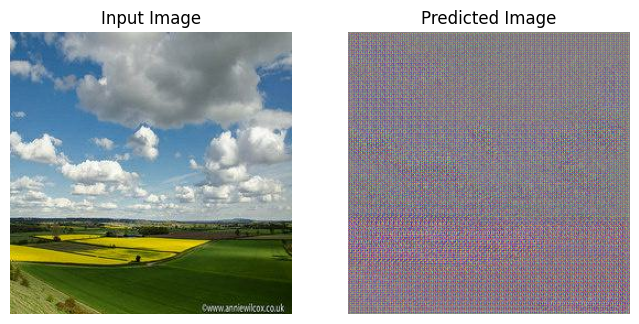

In [ ]:
generate_images(generator_g, sample_input)

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

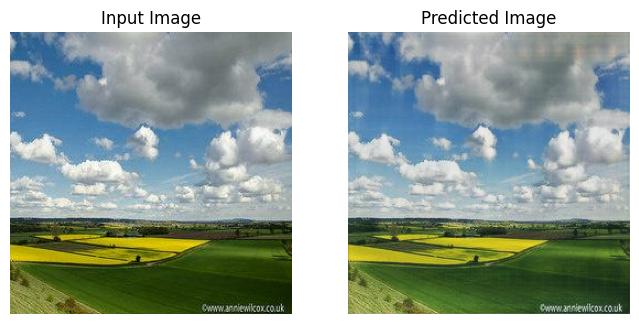

Time taken for epoch 10 is 54.870898723602295 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((photo_train_images, monet_train_images)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_input)

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

<font color = 'blue'>
Generating data from the trained model using the test set that we saved in the dataset photo_images.

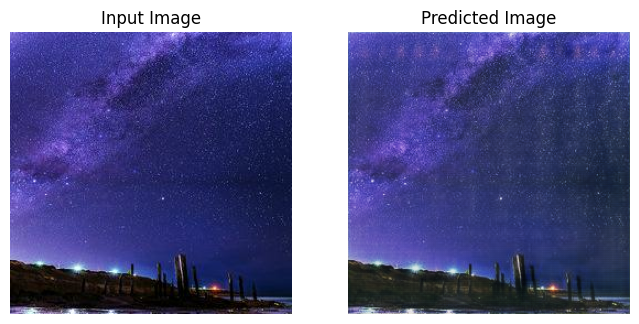

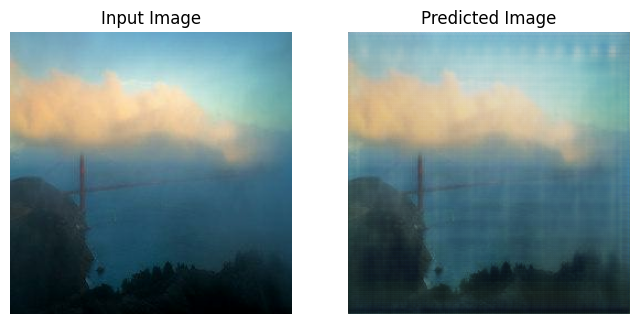

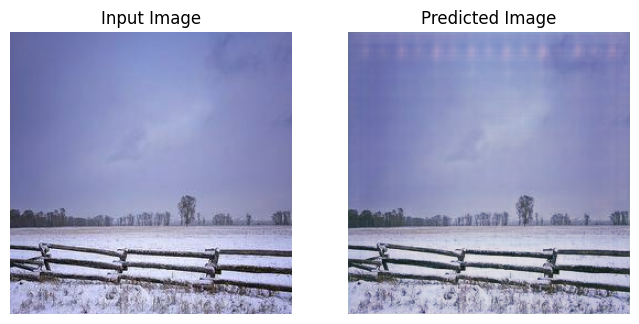

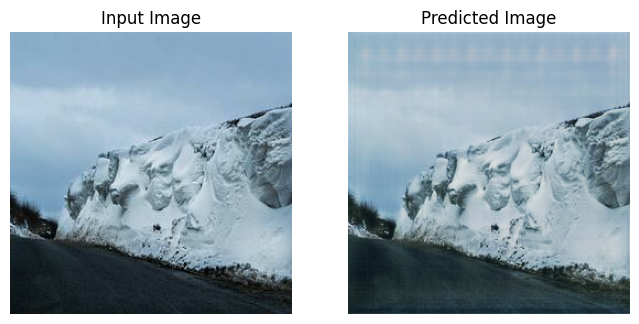

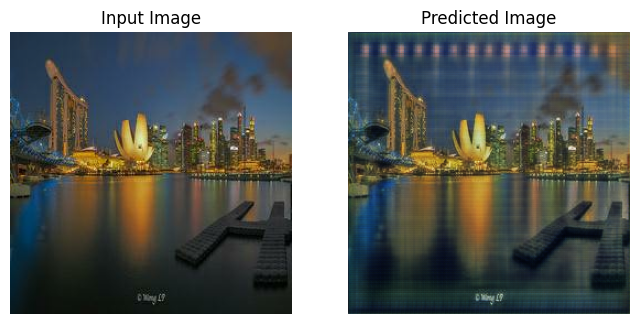

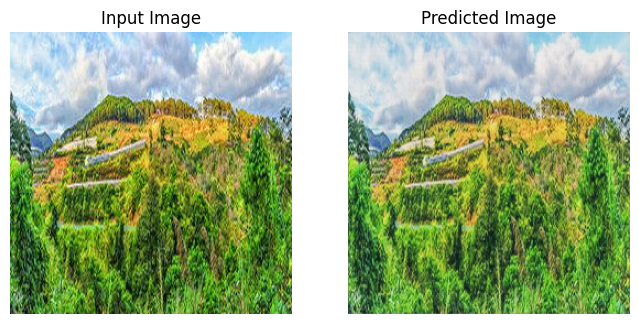

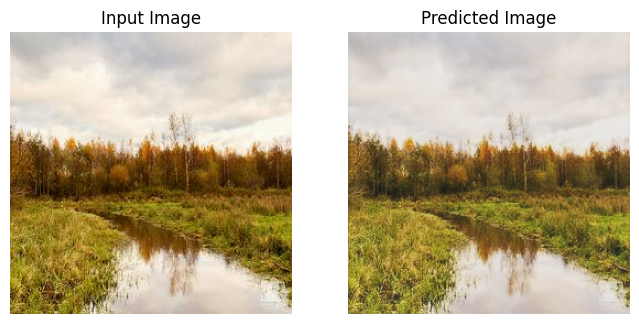

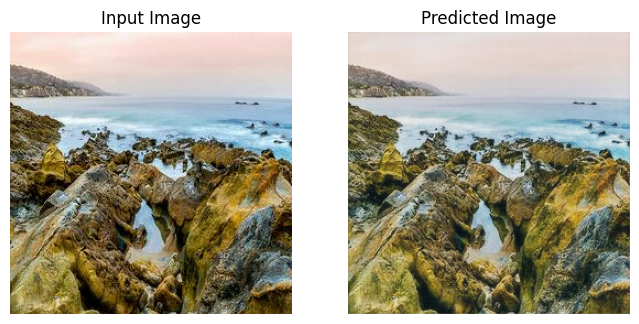

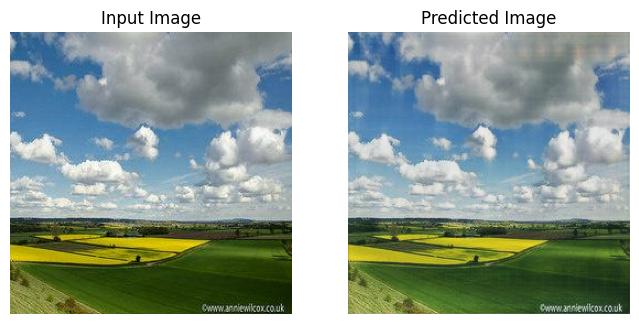

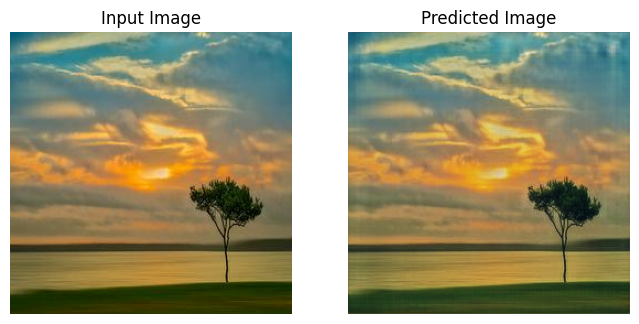

In [ ]:
for ex in photo_images:
  generate_images(generator_g, ex)

<font color = 'blue'>
Next we load all the images in the photo_jpg folder. We will convert these 7000 images to Monet style using our trained cycle GAN.

In [ ]:
photo_test_images = [load_image(os.path.join(gan_getting_started_path, 'photo_jpg', i)) for i in photo_files]

In [ ]:
photo_test_images = tf.data.Dataset.from_tensor_slices(photo_test_images)

In [ ]:
photo_test_images = photo_test_images.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
import zipfile
import os
from tqdm import tqdm

# Creating a directory to store the generated images
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)


for i, img in tqdm(enumerate(photo_test_images), leave = True):
    prediction = generator_g(img)
    # Saving the generated image
    generated_image_path = os.path.join(output_dir, f"generated_image_{i}.png")
    plt.imsave(generated_image_path, prediction[0].numpy() * 0.5 + 0.5)

# Creating a zip file containing the generated images and deleting rest of the images from the folder
# leaving only the image.zip file
zip_filename = "generated_images.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
  for root, _, files in os.walk(output_dir):
    for file in files:
      zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))
      os.remove(os.path.join(root, file))


7038it [10:35, 11.08it/s]
